# User defined Functions

In [84]:
def remove_outliers(df,col_list):
    '''Removes outliers from dataframe DF using the 
    IQR * 1.5 rule.  
    Applies only to the columns in list COL_LIST'''
    
    for i in col_list:
        q1 = df[i].quantile(0.25)
        q3 = df[i].quantile(0.75)

        iqr = q3 - q1

        lower_bound = q1 -(1.5 * iqr) 
        upper_bound = q3 +(1.5 * iqr)


        df.drop(df[ (df[i] > upper_bound) | (df[i] < lower_bound) ].index , inplace=True)
        return(df)

#Get independent variable
def create_y(df,y_name):
    y=df[y_name]
    return y

#get dependent variable
def create_x(df,y_name):
    x=df.drop(labels=y_name,axis=1)
    return x

#Create train-test x,ys
def create_train_test_data(x,y):
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=.30,random_state=123)
    return x_train,x_test,y_train,y_test

#Create ColumnTransformer to enable transforming of both numerical & categorical data
def col_transformer(x): 

    numerical_columns_selector = selector(dtype_exclude=object)
    categorical_columns_selector = selector(dtype_include=object)

    numerical_columns = numerical_columns_selector(x)
    categorical_columns = categorical_columns_selector(x)


    categorical_preprocessor = OneHotEncoder(drop='first',handle_unknown="ignore")
    numerical_preprocessor = StandardScaler()


    preprocessor = ColumnTransformer([('cat', categorical_preprocessor, categorical_columns),
                                      ('num', numerical_preprocessor, numerical_columns)],sparse_threshold=0)
    return preprocessor


#Run statmodel OLS
def sm_OLS(x_train_scaled,x_test_scaled,y_train):
    x_train_const_scaled = sm.add_constant(x_train_scaled) # adding a constant so that formula understands y=mx+b that b<>0
    model = sm.OLS(y_train, x_train_const_scaled).fit()
    y_pred_train = model.predict(x_train_const_scaled) 

    x_test_const_scaled = sm.add_constant(x_test_scaled) # adding a constant so that formula understands y=mx+b that b<>0
    y_pred_test = model.predict(x_test_const_scaled) 
    return model,y_pred_train,y_pred_test

#Collect results for analysis
def gather_results(model,y_pred_train,y_train):
    m_mse=mse(y_train,y_pred_train)
    rmse=math.sqrt(mse(y_train,y_pred_train))
    r_mae=mae(y_train,y_pred_train)
    r_squared=model.rsquared
    r_squared_adj=model.rsquared_adj
    df_data={'MSE':[round(m_mse,2)],'RMSE':[round(rmse,3)],'R-Squared':[round(r_squared,3)],'R-Squared-Adj':[round(r_squared_adj,3)]}
    temp_df=pd.DataFrame(df_data)
    return temp_df

# Import everything

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import quantile_transform
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import OneHotEncoder  ##. better to use dummy from pandas 
from sklearn.preprocessing import PowerTransformer
from scipy.stats import boxcox
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from scipy.stats import boxcox
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
pd.options.display.max_rows = 50
import qgrid
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
import math


# Read file

In [86]:
file_path=r"C:\Users\MichaelTaylo_c9zoof3\Documents\GitHub\IH_Berliners\Data\5. Updated with continent codes\nutrition_demographic_covid_continent_2.csv"
df=pd.read_csv(file_path)

## Remove columns with high multicolinearity

In [87]:
#Complete the actual removal

corr_matrix=df.corr().abs()
upper_triangle=corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(bool))
droppable_columns=[column for column in upper_triangle.columns if any(upper_triangle[column] > 0.75)]

#[df.drop(column,axis=1, inplace=True) for column in droppable_columns]

# Review numerical data

In [88]:
#get numericals
numericals=df._get_numeric_data()

# Code used per project

In [89]:
#Which dataframe did I use?

df_used = numericals.copy()        #numbers only
#df_used = df.copy()                #numbers + categorical

## Remove outliers

In [90]:
#Remove outliers
outlier_list=numericals.columns
#remove_outliers(df_used,outlier_list)

## Create x-y split and check initial outcomes of model

## SHAPELY

In [91]:

#Prep X-Y Split
y_name='covid_fatality_rate'
y=create_y(df_used,y_name)
x=create_x(df_used,y_name)

#Create train-test data
x_train,x_test,y_train,y_test=create_train_test_data(x,y)

#Create transformer to normalize data
transformer=col_transformer(x_train)

#Normalize/scale data
x_train_scaled=transformer.fit_transform(x_train)
x_test_scaled=transformer.transform(x_test)
feature_names=transformer.get_feature_names_out()
x_train_scaled=pd.DataFrame(data=x_train_scaled,columns=feature_names)
x_test_scaled=pd.DataFrame(data=x_test_scaled,columns=feature_names)

#Create OLS model using statsmodel
y_train=y_train.values.reshape(-1,1)
model,y_pred_train,y_pred_test=sm_OLS(x_train_scaled,x_test_scaled,y_train)

#Gather results of the OLS
#y_pred_test=y_pred_test.values.reshape(-1,1)
results_model=gather_results(model,y_pred_train,y_train)
print(results_model)


   MSE  RMSE  R-Squared  R-Squared-Adj
0  0.0   0.0      0.876          0.635


In [92]:
from sklearn.ensemble import RandomForestRegressor
model=RandomForestRegressor(max_depth=6, random_state=0, n_estimators=10)

model.fit(x_train_scaled, y_train)

y_pred_test=model.predict(x_test_scaled)


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [93]:
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
# import shap library
import shap

# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_train)

# visualize the first prediction's explanation 
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], x_train.iloc[0,:])

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [94]:
shap.force_plot(explainer.expected_value, shap_values, x_train)

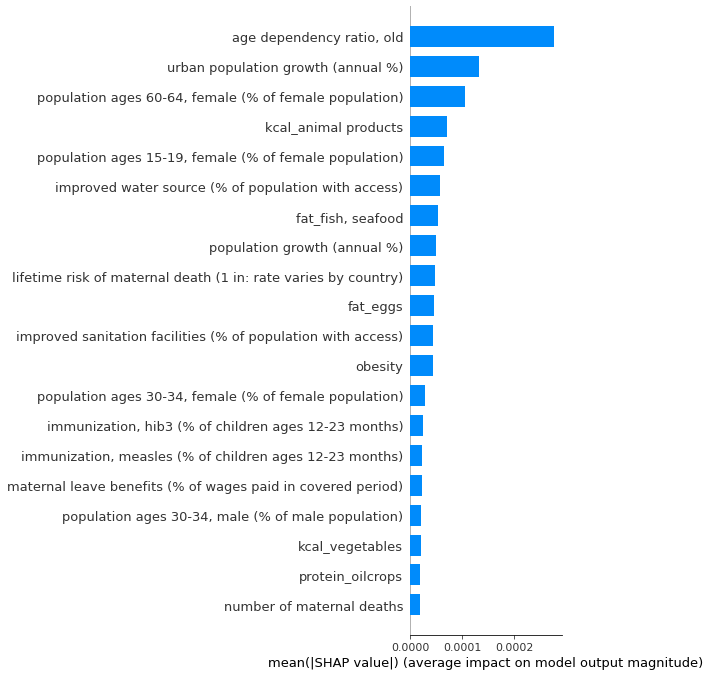

In [95]:
shap_values = shap.TreeExplainer(model).shap_values(x_train)
shap.summary_plot(shap_values, x_train, plot_type="bar")

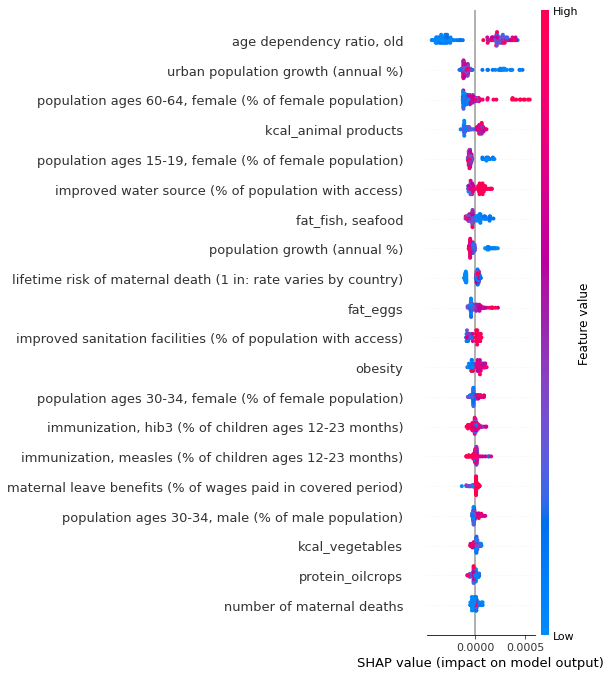

In [96]:
shap.summary_plot(shap_values, x_train)

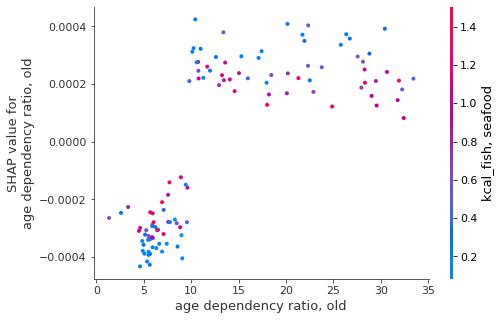

In [97]:
shap.dependence_plot('age dependency ratio, old', shap_values, x_train)